# Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prereq

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from wordcloud import WordCloud

In [4]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.8 MB/s eta 0:00:00


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.7 MB/s eta 0:00:00


In [6]:
!pip install emoji
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=729b7eaa0e7c54e7cd30c3819bdd58adb46134b995bcf1c72d6ce8c618ef6967
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.0 MB/s eta 0:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from pandas_profiling import ProfileReport


import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup


<ipython-input-7-7dbb589e8113>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
import json

In [ ]:
import re
import random
import time

# Config

In [ ]:
class config:
  SEED = 42
  K_FOLDS = 5
  MODEL_PATH_TO_LOAD = '/content/drive/MyDrive/model_sentiment140_v2_cont3.pt'
  MODEL_PATH = '/content/drive/MyDrive/model_sentiment140_v2_final.pt'
  MAX_LEN =[128]
  PRE_TRAINED_MODEL = ['cardiffnlp/twitter-roberta-base-sentiment','vinai/bertweet-base','kornosk/polibertweet-mlm', 'm-newhauser/distilbert-political-tweets' ]
  EPOCHS = 20
  LEARNING_RATE = [2e-5,3e-5,5e-5]
  BATCH_SIZE = 64
  NUM_WORKERS = 2 
  EPS=1e-8
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
config.DEVICE

device(type='cuda', index=0)

# Read data

https://www.kaggle.com/datasets/kazanova/sentiment140

In [ ]:
path_sentiment140='/content/drive/MyDrive/dataset-sentiment/training.1600000.processed.noemoticon.csv'

In [ ]:
DATASET_COLUMNS=['target','ids','date','query','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(path_sentiment140,  encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [ ]:
df

,target,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
df = df[['target','text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
def check_df(df, target_col):
  df= df.dropna(subset=[target_col])
  df=df.reset_index()
  return df

In [ ]:
print("Len df:", len(df))
df = check_df(df,'target')
print("Len df:", len(df))
df  = df[~df.duplicated(subset=['text'])==True]
print("Len df:", len(df))

Len df: 1600000
Len df: 1600000
Len df: 1581466


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)
print('Training samples: ', len(df_train))
print('Test samples: ', len(df_test))

Training samples:  1265172
Test samples:  316294


In [ ]:
def plot_distribution(df, target_col, title):
  distribution = df[target_col].value_counts()
  plt.figure(figsize=(10,4))
  plt.title(title)
  plt.bar(distribution.index, distribution.values)
  plt.show()

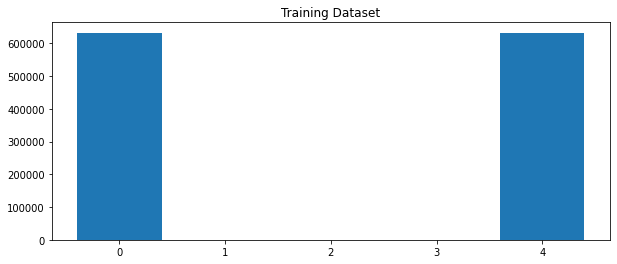

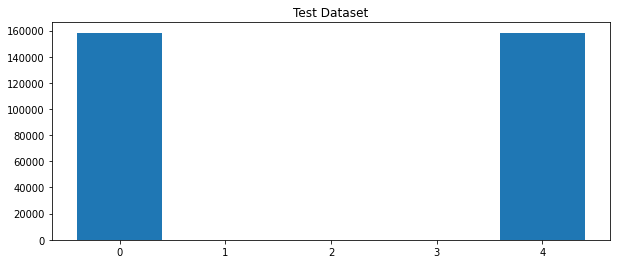

In [ ]:
%matplotlib inline
plot_distribution(df_train,'target','Training Dataset')
plot_distribution(df_test,'target','Test Dataset')

In [ ]:
pd.set_option("display.max_columns", None)

Positive    791281
Negative    790185
Name: target, dtype: int64


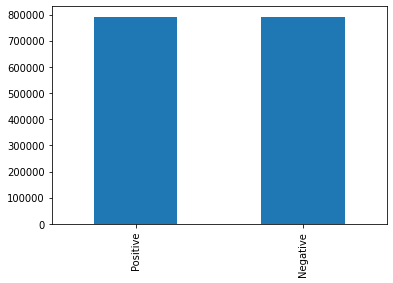

In [ ]:
# Visualising the distribution of the target variable.

sentiment = {0:"Negative", 4:"Positive"}
print(df.target.apply(lambda x: sentiment[x]).value_counts())
df.target.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

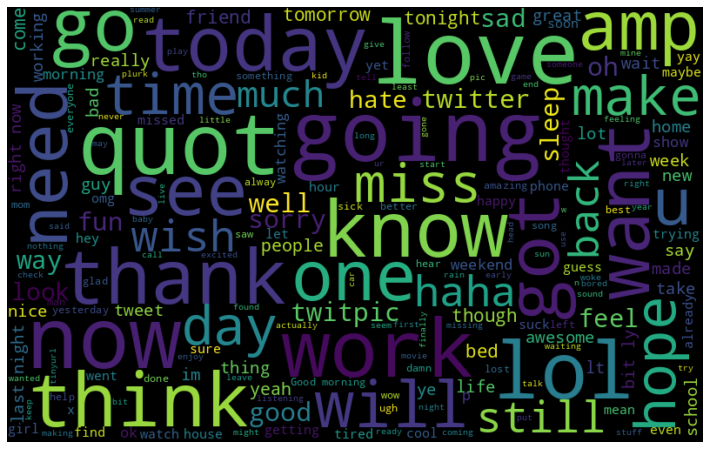

In [ ]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in df['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

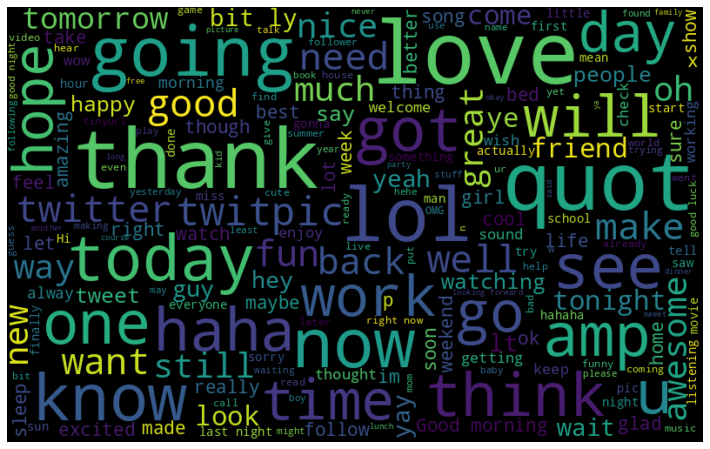

In [ ]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in df['text'][df['target']==4]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in df['text'][df['target']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data preparation

###TweetTokenizer for BERT like model

In [ ]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base

def preprocess(text):
    new_text = []
    if type(text)==float:
      print(text)
    for t in text.split(" "):
        t = '@USER' if t.startswith('@') and len(t) > 1 else t
        t = 'HTTPURL' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
print(
  preprocess(
      "SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
  )
)

SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms HTTPURL via @USER


In [ ]:
df_train.dropna(subset=['text'], inplace=True)
df_test.dropna(subset=['text'], inplace=True)

In [ ]:
df_train.head(1)

,index,target,text
382831,382831,0,@JohnhampsonUK Not keen myself. It does smell...


In [ ]:
df_train.dropna(subset=['target'], inplace=True)
df_test.dropna(subset=['target'], inplace=True)

In [ ]:
df_train['final'] = df_train['text'].apply(lambda x: preprocess(x))
df_test['final'] = df_test['text'].apply(lambda x: preprocess(x))

In [ ]:
df_train[:4][['text','final']]

,text,final
382831,@JohnhampsonUK Not keen myself. It does smell...,@USER Not keen myself. It does smell like a f...
1057395,is listening to the new album &quot;Happiness ...,is listening to the new album &quot;Happiness ...
340555,"@with2ns I had that last week, it was horribl...","@USER I had that last week, it was horrible, ..."
309161,Just when you think you have fixed a server....,Just when you think you have fixed a server....


###BERT Tokenizer

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL[1])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
config.MAX_LEN[0]

128

In [ ]:
def tokenize_function(text, tokenizer):
    tok = tokenizer(text, add_special_tokens=True, padding="max_length", max_length = config.MAX_LEN[0],truncation=True, return_tensors="pt")
    return tok['input_ids'], tok['attention_mask']

In [ ]:
df_train['input_ids'],df_train['attention_mask'] = zip(*df_train.apply(lambda x: tokenize_function(x['final'],bert_tokenizer), axis=1 ))

In [ ]:
df_test['input_ids'], df_test['attention_mask'] = zip(*df_test.apply(lambda x: tokenize_function(x['final'],bert_tokenizer), axis=1))

In [ ]:
df_train.sample(1)

,index,target,text,final,input_ids,attention_mask
486889,486889,0,@HaDAk yep. 4th grade. Desert storm.,@USER yep. 4th grade. Desert storm.,"[[tensor(0), tensor(5), tensor(460), tensor(23...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


### Download BERT pre-trained model

In [ ]:
bert_model = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL[1])

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
config.PRE_TRAINED_MODEL[1]

'vinai/bertweet-base'

### Create Dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, df, encoded_y):
      self.df = df
      self.y = encoded_y

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      item = self.df.iloc[idx]
      text = item['final']
      label = self.y[idx]

      return {
          'text': text,
          'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
          'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),
          'labels' : torch.tensor(label).to(config.DEVICE)
      }

In [ ]:
df_train.head(1)

,index,target,text,final,input_ids,attention_mask
382831,382831,0,@JohnhampsonUK Not keen myself. It does smell...,@USER Not keen myself. It does smell like a f...,"[[tensor(0), tensor(5), tensor(319), tensor(13...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
len(df_test)

316294

In [ ]:
config.DEVICE

device(type='cuda', index=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_trian, df_val = train_test_split(df_train, test_size=0.1)
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train.target.to_list())
y_test = encoder.transform(df_test.target.to_list())
y_val = encoder.transform(df_val.target.to_list())

In [ ]:
train_set = CustomDataset(df_train, y_train)
test_set = CustomDataset(df_test, y_test)
val_set = CustomDataset(df_val, y_val)
print("Train:", len(train_set),"Test:", len(test_set),"Validation:", len(val_set))

Train: 1265172 Test: 316294 Validation: 126518


In [ ]:
df_test.head(2)

,index,target,text,final,input_ids,attention_mask
569335,569335,0,@Waltron_2point0 textiles and two sciences,@USER textiles and two sciences,"[[tensor(0), tensor(5), tensor(36747), tensor(...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
899850,899850,4,eating chocolate chip ice cream yuuummmm!,eating chocolate chip ice cream yuuummmm!,"[[tensor(0), tensor(1114), tensor(2198), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
print(len(test_set))
print(test_set[2])

316294


<ipython-input-41-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),


{'text': 'currently coughing  ugh nasty outside .man f this im bout to go practice', 'input_ids': tensor([[    0,  1691, 18634,  2299,  3467,   929,   639,   171,   952,    33,
           199,   736,     9,    82,  1797,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,    

<ipython-input-41-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


### Create Dataloader

In [ ]:
len(test_set)

316294

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=config.BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.BATCH_SIZE)

In [ ]:
data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].squeeze().shape)
print(data['labels'].shape)
print(data['attention_mask'].squeeze().shape)

<ipython-input-41-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),


dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([64, 128])
torch.Size([64])
torch.Size([64, 128])


<ipython-input-41-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


# Classifier

768 -> 50 -> 2

In [ ]:
class TweetClassifier(nn.Module):
    def __init__(self, bertModel, out_feat, freeze_bert):
        super().__init__()
        D_in, H, D_out = 768, 50, out_feat
        self.bert = bertModel
        self.classifier = nn.Sequential(
            nn.Linear(D_in,H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )
        # Freeze the pre-trained layers of BERT model
        if freeze_bert==True:
          for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask )
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

# Evaluate

In [ ]:
def evaluate(model, val_dataloader, loss_fn, device):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        mask = batch['attention_mask'].squeeze(1).to(device)
        input_id = batch['input_ids'].squeeze(1).to(device)
        targets = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_id, mask)

        loss = loss_fn(logits, targets)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        batch_acc = (preds == targets).cpu().numpy().mean() 
        val_accuracy.append(batch_acc)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

# Train

In [ ]:
def train(model, train_dataloader, val_dataloader, model_path, epochs):
  print(f"Start training...\n")

  min_epoch_loss = np.Inf
  # scopul pe timpul antrenarii e sa se minimizeze functia de cost (loss) 
  log_info = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
  trigger_times = 0
  patience = 4
  best_model = model

  for epoch in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12}| {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Tracking variables
    batch_loss, batch_counts = 0, 0  # updated from 20 to 20 batches
    epoch_loss = []
    epoch_accuracy = []

    # Put the model into the training mode
    model.train() # actualizez weight-urile

    for step, batch in enumerate(train_dataloader):
      batch_counts +=1

      model.zero_grad() 
      
      mask = batch['attention_mask'].squeeze(1).to(config.DEVICE)
      input_id = batch['input_ids'].squeeze(1).to(config.DEVICE)
      targets = batch["labels"].type(torch.LongTensor)
      targets = targets.to(config.DEVICE)

      logits =  model(input_id, mask)
      
      loss = loss_fn(logits, targets)
      batch_loss += loss.item()
      epoch_loss.append(loss.item())

      preds = torch.argmax(logits,dim=1).flatten()

      batch_acc = (preds==targets).cpu().numpy().mean()
      epoch_accuracy.append(batch_acc)

      loss.backward()
      optimizer.step()
      
      # Print the loss values and time elapsed for every 20 batches
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
          time_elapsed = time.time() - t0_batch

          print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_acc:^12.6f} |{'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
          
          batch_loss, batch_counts = 0, 0
          t0_batch = time.time()

    epoch_loss = np.mean(epoch_loss)
    epoch_accuracy = np.mean(epoch_accuracy)


    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn, config.DEVICE)
    time_elapsed = time.time() - t0_epoch

    print("-"*70)
    print(f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f} |{epoch_accuracy:^12.6f}| {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
    log_info['train_loss'].append((epoch, epoch_loss))
    log_info['train_acc'].append((epoch, epoch_accuracy))
    log_info['val_loss'].append((epoch, val_loss))
    log_info['val_acc'].append((epoch, val_accuracy))
    print("-"*70)
    
    if val_loss < min_epoch_loss:
      min_epoch_loss = val_loss
      trigger_times = 0 
      print('Trigger times: 0')
      print(f"Saving model with val loss: {val_loss} and validation accuracy: {val_accuracy}")
      torch.save(model, model_path)
      best_model = model
    else:
      trigger_times += 1
      print('Trigger Times:', trigger_times)
    if trigger_times > patience:
        print('Early stopping!\nStart to test process.')
        return best_model, log_info

  print(f"Training Complete")
  return best_model, log_info

# Start training

## old

In [ ]:
config.DEVICE

device(type='cuda', index=0)

In [ ]:
model = TweetClassifier(bert_model, 2, True).to(config.DEVICE)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(config.DEVICE)

optimizer = AdamW(model.parameters(),lr=config.LEARNING_RATE[0], 
                  eps=config.EPS, correct_bias=False, no_deprecation_warning=True)

best_model, log_info = train(model, train_dataloader, val_dataloader, config.MODEL_PATH, config.EPOCHS)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


<ipython-input-51-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-51-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


Streaming output truncated to the last 5000 lines.
   1    |  16340  |   0.532499   |   0.671875   |    -      |     -     |   9.02   
   1    |  16360  |   0.505031   |   0.812500   |    -      |     -     |   8.86   
   1    |  16380  |   0.533398   |   0.703125   |    -      |     -     |   8.98   
   1    |  16400  |   0.539496   |   0.718750   |    -      |     -     |   8.99   
   1    |  16420  |   0.507849   |   0.734375   |    -      |     -     |   8.82   
   1    |  16440  |   0.543787   |   0.687500   |    -      |     -     |   9.07   
   1    |  16460  |   0.524635   |   0.750000   |    -      |     -     |   8.88   
   1    |  16480  |   0.536041   |   0.750000   |    -      |     -     |   8.95   
   1    |  16500  |   0.507211   |   0.796875   |    -      |     -     |   8.96   
   1    |  16520  |   0.540627   |   0.687500   |    -      |     -     |   8.82   
   1    |  16540  |   0.511620   |   0.703125   |    -      |     -     |   9.02   
   1    |  16560  |   0.5

## new

In [ ]:
config.EPOCHS = 1
loaded_model = torch.load(config.MODEL_PATH_TO_LOAD)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(config.DEVICE)

optimizer = AdamW(loaded_model.parameters(),lr=config.LEARNING_RATE[0], 
                  eps=config.EPS, correct_bias=False, no_deprecation_warning=True)

best_model, log_info = train(loaded_model, train_dataloader, val_dataloader, config.MODEL_PATH, config.EPOCHS)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


<ipython-input-41-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-41-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


   1    |   20    |   0.516581   |   0.734375   |    -      |     -     |   11.65  
   1    |   40    |   0.513324   |   0.718750   |    -      |     -     |   8.20   
   1    |   60    |   0.477142   |   0.765625   |    -      |     -     |   8.05   
   1    |   80    |   0.470343   |   0.781250   |    -      |     -     |   8.27   
   1    |   100   |   0.472619   |   0.843750   |    -      |     -     |   8.27   
   1    |   120   |   0.487247   |   0.781250   |    -      |     -     |   8.35   
   1    |   140   |   0.467251   |   0.875000   |    -      |     -     |   8.51   
   1    |   160   |   0.491636   |   0.765625   |    -      |     -     |   8.39   
   1    |   180   |   0.487993   |   0.750000   |    -      |     -     |   8.64   
   1    |   200   |   0.481253   |   0.812500   |    -      |     -     |   8.77   
   1    |   220   |   0.457381   |   0.828125   |    -      |     -     |   9.03   
   1    |   240   |   0.493670   |   0.796875   |    -      |     -     |   

# Check model's performance during training

In [ ]:
log_info  

{'train_loss': [(0, 0.481893993675561)],
 'train_acc': [(0, 0.7662030831099196)],
 'val_loss': [(0, 0.42395137183341824)],
 'val_acc': [(0, 0.8062165130482025)]}

In [ ]:
def Convert(tup, di):
  di={"epoch":[],"val":[]}
  for a, b in tup:
    di['epoch'].append(a)
    di['val'].append(b)
  return di

def plot_performance(log_info):
  dict_train={}
  dict_val={}

  dict_train = Convert(log_info['train_acc'], dict_train)
  dict_val = Convert(log_info['val_acc'], dict_val)

  dict_train_loss={}
  dict_val_loss={}

  dict_train_loss = Convert(log_info['train_loss'], dict_train_loss)
  dict_val_loss = Convert(log_info['val_loss'], dict_val_loss)

  fig = plt.figure()
  plt.plot(dict_train['epoch'], dict_train['val'] , 'bo', label = 'Training Accuracy')
  plt.plot(dict_val['epoch'], dict_val['val'], 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()


  fig = plt.figure()
  plt.plot(dict_train_loss['epoch'], dict_train_loss['val'] , 'bo', label = 'Training Loss')
  plt.plot(dict_val_loss['epoch'], dict_val_loss['val'], 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

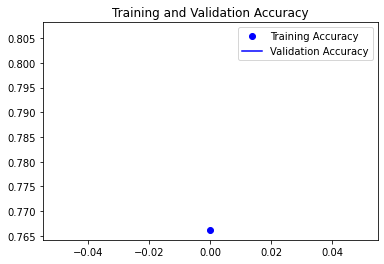

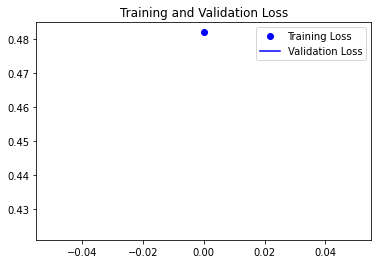

In [ ]:
plot_performance(log_info)

# Evaluate on test data

In [ ]:
loaded_model = torch.load(config.MODEL_PATH)
test_loss, test_accuracy = evaluate(loaded_model, test_dataloader,loss_fn, config.DEVICE)

<ipython-input-41-e84654f0f2ef>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids' : torch.tensor(item['input_ids']).to(config.DEVICE),
<ipython-input-41-e84654f0f2ef>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask' : torch.tensor(item['attention_mask']).to(config.DEVICE),


In [ ]:
print("Model ",config.MODEL_PATH,":\nLOSS =",test_loss,"\nACCURACY =",test_accuracy)

Model  /content/drive/MyDrive/model_sentiment140_v2_final.pt :
LOSS = 0.42392683468100373 
ACCURACY = 0.8064402943556545


# Get predictions

In [ ]:
def get_targets_and_predictios_as_tensors(dataloader,model):
  predictions = []
  targets = []
  for batch in dataloader:
    input_ids = batch['input_ids']
    masks = batch['attention_mask']
    batch_targets = batch['labels']

    with torch.no_grad():
      batch_predictions = model(input_ids.squeeze(1),masks.squeeze(1))
      batch_predictions = torch.argmax(batch_predictions, dim=1).flatten()
      predictions.append(batch_predictions.cpu())
      targets.append(batch_targets.cpu())


  final_predictions = np.concatenate(predictions)
  final_targets = np.concatenate(targets)

  return final_targets, final_predictions

In [ ]:
final_targets, final_predictions = get_targets_and_predictios_as_tensors(test_dataloader, loaded_model)

correct_classifications = sum(final_targets==final_predictions)
misclassified = len(final_predictions) - correct_classifications

print("TEST DATASET:  number of samples misclassified: ", str(misclassified),"/",str(len(final_predictions)))
print("TEST DATASET:  number of samples correct classified: ", correct_classifications,"/",str(len(final_predictions)))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


print ('\n*Classification Report for Test Data:\n', classification_report(final_targets, final_predictions))

cm = confusion_matrix(final_targets, final_predictions, normalize='true')
